In [1]:
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Add parent directory to path to allow import of config.py
sys.path.append("..")

import config as conf

In [2]:
data = pd.read_csv(f'{conf.DATA_PATH}{conf.FORMATTED_DATAFILE}')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Census Enrollment                14 non-null     float64
 1   Census Fill Rate                 14 non-null     float64
 2   Count of Migrated Data           14 non-null     float64
 3   Current Enrollment               14 non-null     float64
 4   Current Fill Rate                14 non-null     float64
 5   Enrollment Capacity              14 non-null     float64
 6   Ftef                             14 non-null     float64
 7   Ftes                             14 non-null     float64
 8   Ftes/Ftef                        14 non-null     float64
 9   Number Retained                  14 non-null     float64
 10  Number Successful                14 non-null     float64
 11  Retention Rate                   14 non-null     float64
 12  Sec. Count              

In [3]:
# Split data randomly into training and testing sets
training_data = data.sample(frac=0.8)
test_data = data.drop(training_data.index)

# Seperate dependent and independent variable
training_features = training_data.copy()
test_features = test_data.copy()

training_labels = training_features.pop('Next Semester Census Enrollment')
test_labels = test_features.pop('Next Semester Census Enrollment')

In [4]:
# Setup normalization layer for features
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(training_features))

In [4]:
# Build deep neural network model
def build_and_compile_model(
    normalizer,
    units, 
    learning_rate
):
    '''Takes pre-adapted normalizer and some hyperparameters, returns
    compiled model'''
    
    model = keras.Sequential([
        norm,
        layers.Dense(units, activation='relu'),
        layers.Dense(units, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(
        loss='mean_absolute_error',
        optimizer=tf.keras.optimizers.Adam(learning_rate)
    )
    
    return model

In [6]:
# Build the model and check its architecture
dnn_model = build_and_compile_model(
    normalizer,
    64,
    0.02
)

dnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 23)                47        
_________________________________________________________________
dense (Dense)                (None, 64)                1536      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 5,808
Trainable params: 5,761
Non-trainable params: 47
_________________________________________________________________


In [7]:
%%time
history = dnn_model.fit(
    training_features, 
    training_labels,
    verbose=0,
    epochs=500
)

CPU times: user 7.77 s, sys: 604 ms, total: 8.37 s
Wall time: 11.9 s


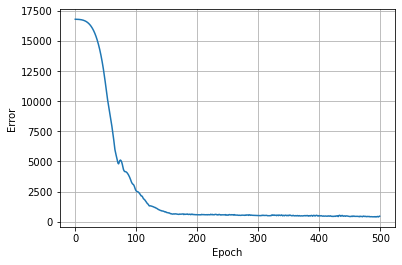

In [8]:
def plot_loss(history):
    '''Takes training history object from keras model.fit
    and plots loss'''
    plt.plot(history.history['loss'], label='loss')
    #plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    #plt.legend()
    plt.grid(True)

plot_loss(history)

In [9]:
dnn_model.evaluate(test_features, test_labels, verbose=1)

1/1 [==============================] - 0s 226ms/step - loss: 2251.8630


2251.863037109375

In [10]:
X = data.drop('Next Semester Census Enrollment', axis=1)
y = data['Next Semester Census Enrollment']
predicted_enrollment = dnn_model.predict(X)

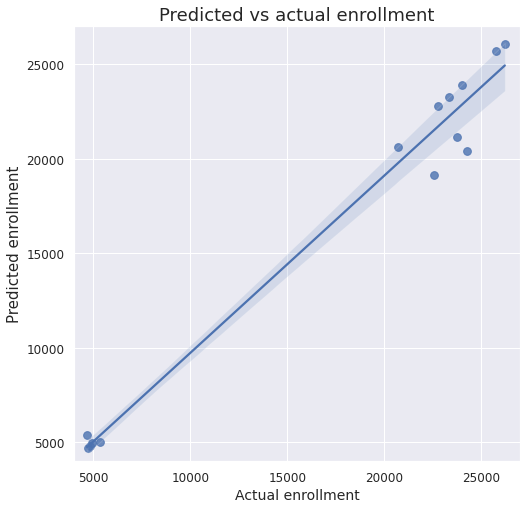

In [11]:
# Grab actual enrollment numbers to compare with
actual_enrollment = y

# Plot actual enrollment vs predicted enrollment
sns.set(rc={'figure.figsize':(8,8)})
ax = sns.regplot(y=predicted_enrollment, x=actual_enrollment, fit_reg=True, scatter_kws={'s':60})
ax.tick_params(labelsize=12)
ax.set_title('Predicted vs actual enrollment', fontsize=18)
ax.set_xlabel('Actual enrollment', fontsize=14)
ax.set_ylabel('Predicted enrollment', fontsize=15)
#ax.set_aspect('equal', 'box')
ax.set_xlim(4000, 27000)
ax.set_ylim(4000, 27000)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

Looks pretty good! Still very worried about overfitting with such a small dataset. To augment this approach I am going to try something a little unconventional - bootstrap aggragation! The idea is, this dataset is so small and our network is so simple, training completes on the order of seconds. We will use the speed of training to our advantage and train multiple times with different randomly chosen subsets of the data. Then we will use the ensamble of trained networks to make predictions. It will make more sense when you see it (I hope)...

First thing is to encapsulate the major opperations above into functions so we can easily build and train models in a loop.

In [2]:
def create_datasets(data, training_data_fraction, label_column_name):
    '''Takes master data as pandas dataframe splits into train and
    test features and labels, returns a dict of dataframes'''
    
    # Split data randomly into training and testing sets
    training_data = data.sample(frac=training_data_fraction)
    test_data = data.drop(training_data.index)

    # Seperate dependent and independent variable
    training_features = training_data.copy()
    test_features = test_data.copy()

    training_labels = training_features.pop(label_column_name)
    test_labels = test_features.pop(label_column_name)
    
    dataset = {}
    dataset['training_features'] = training_features
    dataset['test_features'] = test_features
    dataset['training_labels'] = training_labels
    dataset['test_labels'] = test_labels
    
    return dataset

In [3]:
def create_normalization_layer(training_features):
    '''Takes a pandas dataframe, returns an adapted tf.keras
    normalization layer'''
    
    normalizer = preprocessing.Normalization()
    normalizer.adapt(np.array(training_features))
    
    return normalizer

In [ ]:
# First make some empty lists to hold our history objects 
# and trained models

num_models = 10

trained_DNN_models = []
training_history_objects = []
test_set_scores = []

# Outer training loop
for i in range(num_models):
    # Make dataset
    dataset = create_datasets(data)
    
    # Adapt normalization layer
    normalizer = create_normalization_layer(dataset['training_features'])
    
    # Build model
    dnn_model = build_and_compile_model(
        normalizer,
        64,
        0.02
    )
    
    # Train model
    history = dnn_model.fit(
        dataset['training_features'], 
        dataset['training_labels'],
        verbose=0,
        epochs=500
    )
    
    # Store results
    trained_DNN_models.append(dnn_model)
    training_history_objects.append(history)
    
    # Evaluate model
    test_score = dnn_model.evaluate(dataset['test_features'], dataset['test_labels'])
    test_set_scores.append(test_score)
